In [1]:
from datasets import load_dataset
from transformers import pipeline
import numpy as np
import pandas as pd 


In [2]:
ds = load_dataset('Falah/Alzheimer_MRI', split='test')

In [3]:
labels = ds.features['label'].names #--> returns unique labels. 
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    #print(f'id: {i}, label:{label}')
    label2id[label] = str(i)
    id2label[str(i)] = label

In [31]:
#Load the fine-tuned ViT model.

checkpoint = 'models/deit-base-patch16-224/checkpoint-3200'
#image_processor = AutoImageProcessor.from_pretrained(checkpoint)
classifier = pipeline("image-classification", model=checkpoint)

In [32]:
index = 918
img = ds["image"][index]
print('actual label-->',id2label[str(ds["label"][index])])

actual label--> Very_Mild_Demented


In [35]:
classifier = pipeline("image-classification", model=checkpoint)
logits = classifier(img)
logits[0]['score']
print('predicted label-->',logits[0]['label'])

predicted label--> Very_Mild_Demented


In [36]:
logits[i]

IndexError: list index out of range

In [37]:
#method-1 continuation : to get the probability array stored according to class label 
#(as against in descending order given by pipeline logits)
def return_class_probability(logits, dict):
    import numpy as np
    class_probability = np.zeros(4)
    for i in range(len(logits)):
        index = dict[logits[i]['label']]
        class_probability[index] = logits[i]['score']
    return(class_probability)

In [38]:
#  Label-0 -- > Mild_Demented 
#  Label-1 -- > Moderate_Demented 
#  Label-2 -- > Non_Demented 
#  Label-3 -- > Very_Mild_Demented
dict = {
    "Mild_Demented":0,
    "Moderate_Demented":1,
    "Non_Demented":2,
    "Very_Mild_Demented":3
}
class_probability = return_class_probability(logits,dict)
print(class_probability)
print(logits)


[0.02712214 0.01853088 0.0009816  0.95336545]
[{'score': 0.9533654451370239, 'label': 'Very_Mild_Demented'}, {'score': 0.027122143656015396, 'label': 'Mild_Demented'}, {'score': 0.01853088289499283, 'label': 'Moderate_Demented'}, {'score': 0.000981598161160946, 'label': 'Non_Demented'}]


In [39]:
# use predicted and groundtruth labels to get the metrics. 
actual = np.array(ds[:]['label'],dtype=int) # get actual labels (groundtruth)
predicted = np.zeros([actual.shape[0],4],dtype=int)
proba = np.zeros([actual.shape[0],4],dtype=float)
for i in range(actual.shape[0]):
    img = ds["image"][i]
    logits = classifier(img)
    proba[i] = return_class_probability(logits,dict)

predicted = np.argmax(proba,axis=1)

In [40]:
print(proba[0:10])
print(predicted[0:10])
print(actual[0:10])

[[1.16031303e-03 4.64065874e-04 2.60310676e-02 9.72344577e-01]
 [6.16053455e-02 1.18533894e-03 1.78680604e-03 9.35422480e-01]
 [2.61885179e-06 2.26764787e-05 9.99804556e-01 1.70196756e-04]
 [6.84208089e-06 7.95250799e-06 7.82220013e-06 9.99977350e-01]
 [9.98864174e-01 5.90746677e-05 8.32295791e-06 1.06849486e-03]
 [9.94031667e-04 1.37173614e-04 1.52940029e-05 9.98853445e-01]
 [8.13767686e-03 3.23597342e-04 9.89484370e-01 2.05436442e-03]
 [1.90288381e-04 5.41844165e-05 9.99739707e-01 1.57928225e-05]
 [1.33737386e-03 5.77524006e-05 9.90104735e-01 8.50011595e-03]
 [6.22052758e-05 1.09698725e-04 3.28055671e-06 9.99824822e-01]]
[3 3 2 3 0 3 2 2 2 3]
[3 0 2 3 0 3 2 2 2 3]


In [41]:
print("estimating accuracy")
#Print overall accuracy
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
mcm = multilabel_confusion_matrix(y_true=actual, y_pred=predicted, labels=[0,1,2,3], samplewise=False)
tn = mcm[:,0,0]
tp = mcm[:,1,1]
fp = mcm[:,0,1]
fn = mcm[:,1,0]
specificity = tn/(tn+fp)
print("Specificity or TNR",np.mean(specificity))

sensitivity = tp/(tp+fn)
print("Sensitivity or TPR or Recall",np.mean(sensitivity))

print("FNR ", 1-np.mean(sensitivity))

print("FPR", 1-np.mean(specificity))


print("Accuracy = ", metrics.accuracy_score(actual, predicted))


#calculate AUC of model
auc = metrics.roc_auc_score(predicted, proba, multi_class='ovr')

#print AUC score
print("AUC =",auc)

per_metrics = {'Accuracy':[metrics.accuracy_score(actual, predicted)],
                      'Specificity':[np.mean(specificity)],
                      'Sensitivity':[np.mean(sensitivity)],
                      'FNR': [1-np.mean(sensitivity)],
                      'FPR': [1-np.mean(specificity)]}
df = pd.DataFrame(per_metrics)
df.to_csv('Results/deit-base-patch16-224.csv')
#print(performanceMetrics)

estimating accuracy
Specificity or TNR 0.9905057688110237
Sensitivity or TPR or Recall 0.9533844483187353
FNR  0.046615551681264744
FPR 0.009494231188976299
Accuracy =  0.97734375
AUC = 1.0


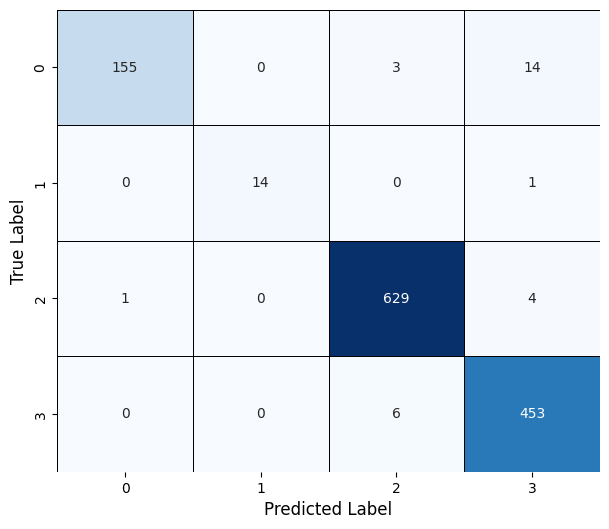

In [42]:
#Code for CM
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(actual, predicted)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7, 6))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, linewidth=0.5,linecolor="black",fmt='')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.savefig("Results/CM-deit-base-patch16-224.pdf")